# Introduction

dE/dx analysis for sPHENIX TPC 2019 data from [FNAL beam test](https://wiki.bnl.gov/sPHENIX/index.php/2019_TPC_FNAL_test_beam). The prototype contains 16 layer readout pads with 50/50 Ne/CF4 gas. The track segment in each layer is ~1.25cm long. The beam is 120 GeV proton beam.

Run with sPHENIX ROOT C++ [Jupyter Lab env at RCF](https://jupyter.sdcc.bnl.gov)

# Input

In [1]:
const TString infile = "scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.root";
// const TString description = "Position scan 2, #eta = 0, 3+ pad clusters";
// const TCut cut = "TPCTrack.nCluster>=14 && Sum$(ClusterY_Rotated>-.3) == 0 && TPCTrack.clusterSizePhi >= 10";
const TString description = "Position scan 2, #eta = 0, 2+ pad clusters";
const TCut cut = "TPCTrack.nCluster>=14 && Sum$(ClusterY_Rotated>-.3) == 0 && TPCTrack.clusterSizePhi >= 8";

In [2]:
%%cpp -d

#include "sPhenixStyle.C"
#include "SaveCanvas.C"

TFile *_file0 = NULL;
TTree *T(nullptr);

In [3]:
// gSystem->Load("libtpc2019.so");

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");
gStyle->SetLegendTextSize(0);

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [4]:
//
if (!_file0)
{
    TString chian_str = infile;
    chian_str.ReplaceAll("ALL", "*");

    TChain *t = new TChain("T");
    const int n = t->Add(chian_str);

    cout << "Loaded " << n << " root files with eventT in " << chian_str << endl;
    assert(n > 0);

    T = t;

    _file0 = new TFile;
    _file0->SetName(infile);
}
//
// description = desc;

Loaded 2 root files with eventT in scan2/tpc_beam_*-0000.evt_TpcPrototypeGenFitTrkFitter.root


In [5]:
T->SetAlias("PhiCenter", "pi/12 + pi");  // center line azimuthal angle for TPC sector 0
T->SetAlias("ClusterY_Rotated", "TPCTrack.clusterX*cos(PhiCenter + pi/2) + TPCTrack.clusterY*sin(PhiCenter + pi/2)");  // center line azimuthal angle for TPC sector 0
T->SetAlias("ClusterX_Rotated", "TPCTrack.clusterX*cos(PhiCenter) + TPCTrack.clusterY*sin(PhiCenter)");  // center line azimuthal angle for TPC sector 0


# QA

Warning in <TClass::Init>: no dictionary for class PHObject is available
Warning in <TClass::Init>: no dictionary for class SvtxTrack_v1 is available
Warning in <TClass::Init>: no dictionary for class SvtxTrack is available
Warning in <TClass::Init>: no dictionary for class TpcPrototypeTrack is available


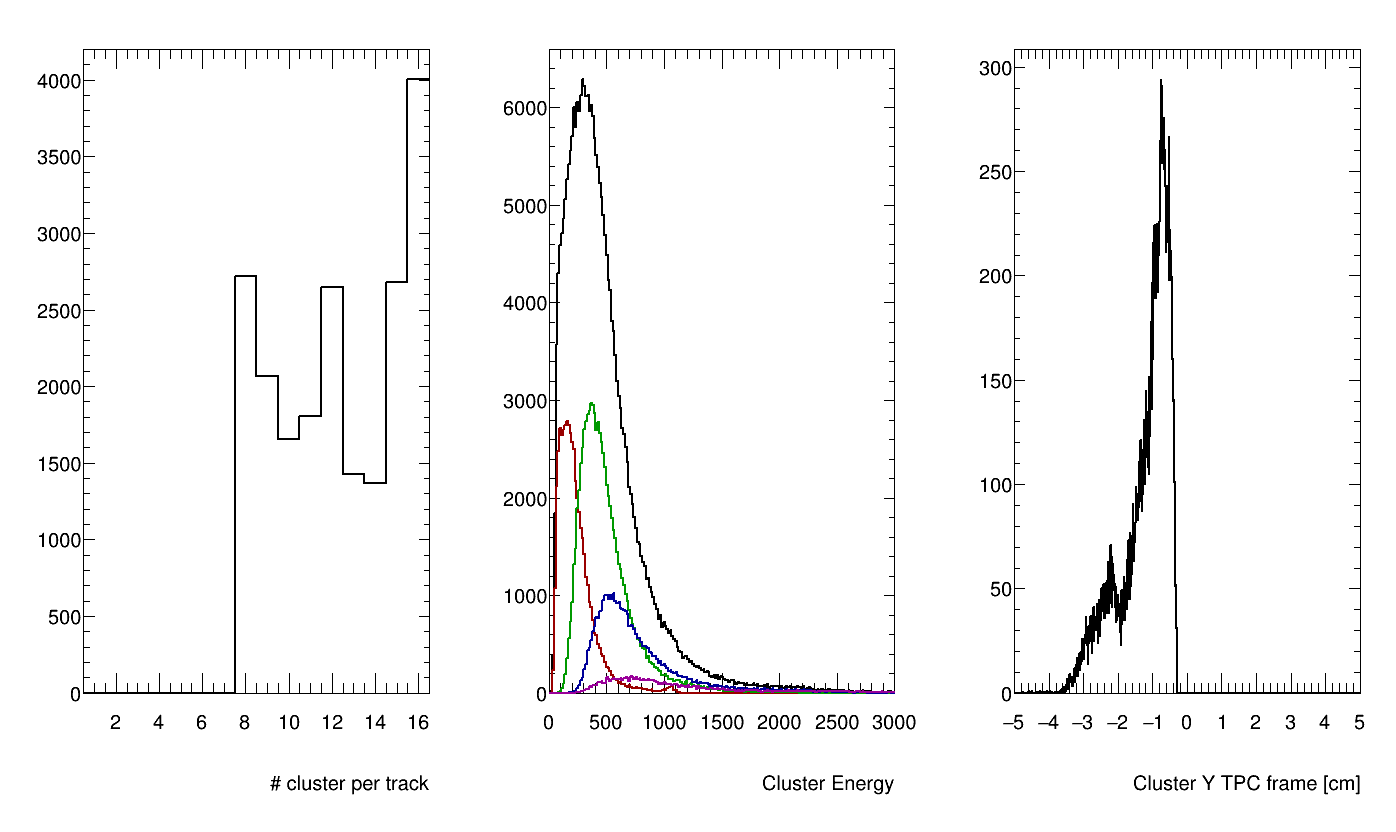

Save TH1 hCluster
Save TH1 hClusterE
Save TH1 hClusterE1
Save TH1 hClusterE2
Save TH1 hClusterE3
Save TH1 hClusterE4
Save TH1 hClusterY


Info in <TCanvas::Print>: png file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackQA.png has been created
Info in <TCanvas::SaveAs>: ROOT file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackQA.root has been created
Info in <TCanvas::SaveSource>: C++ Macro file: scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackQA.C has been generated


In [6]:
{
    TCanvas *c1 = new TCanvas("TrackQA", "TrackQA", 1400, 860);
    c1->Divide(3, 1);
    int idx = 1;
    TPad *p = nullptr;

    p = (TPad *) c1->cd(idx++);
    c1->Update();

    TH1 *hCluster = new TH1F("hCluster", ";# cluster per track", 16, .5, 16.5);
    T->Draw("TPCTrack.nCluster>>hCluster");


    p = (TPad *) c1->cd(idx++);
    c1->Update();

    TH1 *hClusterE = new TH1F("hClusterE", ";Cluster Energy", 200, 0, 3000);
    T->Draw("TPCTrack.clusterE>>hClusterE");

    TH1 *hClusterE1 = (TH1 *) hClusterE -> Clone("hClusterE1");
    hClusterE1->SetLineColor(kRed + 2);
    T->Draw("TPCTrack.clusterE>>hClusterE1",  "TPCTrack.clusterSizePhi == 6", "same");
    TH1 *hClusterE2 = (TH1 *) hClusterE -> Clone("hClusterE2");
    hClusterE2->SetLineColor(kGreen + 2);
    T->Draw("TPCTrack.clusterE>>hClusterE2", "TPCTrack.clusterSizePhi == 8", "same");
    TH1 *hClusterE3 = (TH1 *) hClusterE -> Clone("hClusterE3");
    hClusterE3->SetLineColor(kBlue + 2);
    T->Draw("TPCTrack.clusterE>>hClusterE3",  "TPCTrack.clusterSizePhi ==10", "same");
    TH1 *hClusterE4 = (TH1 *) hClusterE -> Clone("hClusterE4");
    hClusterE4->SetLineColor(kMagenta + 2);
    T->Draw("TPCTrack.clusterE>>hClusterE4",  "TPCTrack.clusterSizePhi >10", "same");


    p = (TPad *) c1->cd(idx++);
    c1->Update();


    //     TH1 *hClusterPhi = new TH1F("hClusterPhi", ";Cluster Phi [rad]", 1000, -4, -2);
    //     T->Draw("TPCTrack.clusterProjectionPhi[]>>hClusterPhi");

    TH1 *hClusterPhi = new TH1F("hClusterY", ";Cluster Y TPC frame [cm]", 1000, -5, 5);
    T->Draw("ClusterY_Rotated>>hClusterY", cut);



    c1->Draw();


    SaveCanvas(c1,
     TString(_file0->GetName()) + TString(c1->GetName()), false);
}

# PDF 

In [7]:
%%cpp -d


Double_t langaufun(Double_t *x, Double_t *par)
{
  //Fit parameters:
  //par[0]=Width (scale) parameter of Landau density
  //par[1]=Most Probable (MP, location) parameter of Landau density
  //par[2]=Total area (integral -inf to inf, normalization constant)
  //par[3]=Width (sigma) of convoluted Gaussian function
  //
  //In the Landau distribution (represented by the CERNLIB approximation),
  //the maximum is located at x=-0.22278298 with the location parameter=0.
  //This shift is corrected within this function, so that the actual
  //maximum is identical to the MP parameter.

  // Numeric constants
  Double_t invsq2pi = 0.3989422804014;  // (2 pi)^(-1/2)
  Double_t mpshift = -0.22278298;       // Landau maximum location

  // Control constants
  Double_t np = 100.0;  // number of convolution steps
  Double_t sc = 5.0;    // convolution extends to +-sc Gaussian sigmas

  // Variables
  Double_t xx;
  Double_t mpc;
  Double_t fland;
  Double_t sum = 0.0;
  Double_t xlow, xupp;
  Double_t step;
  Double_t i;

  // MP shift correction
  mpc = par[1] - mpshift * par[0];

  // Range of convolution integral
  xlow = x[0] - sc * par[3];
  xupp = x[0] + sc * par[3];

  step = (xupp - xlow) / np;

  // Convolution integral of Landau and Gaussian by sum
  for (i = 1.0; i <= np / 2; i++)
  {
    xx = xlow + (i - .5) * step;
    fland = TMath::Landau(xx, mpc, par[0]) / par[0];
    sum += fland * TMath::Gaus(x[0], xx, par[3]);

    xx = xupp - (i - .5) * step;
    fland = TMath::Landau(xx, mpc, par[0]) / par[0];
    sum += fland * TMath::Gaus(x[0], xx, par[3]);
  }

  return (par[2] * step * sum * invsq2pi / par[3]);
}

TF1 *langaufit(TH1 *his,
               const vector<double> &fitrange,
               const vector<double> &startvalues,
               const vector<double> &parlimitslo, const vector<double> &parlimitshi
               //    ,
               //    const vector<double> &fitparams, const vector<double> &fiterrors,
               //    const vector<double> &ChiSqr, Int_t *NDF
)
{
  // Once again, here are the Landau * Gaussian parameters:
  //   par[0]=Width (scale) parameter of Landau density
  //   par[1]=Most Probable (MP, location) parameter of Landau density
  //   par[2]=Total area (integral -inf to inf, normalization constant)
  //   par[3]=Width (sigma) of convoluted Gaussian function
  //
  // Variables for langaufit call:
  //   his             histogram to fit
  //   fitrange[2]     lo and hi boundaries of fit range
  //   startvalues[4]  reasonable start values for the fit
  //   parlimitslo[4]  lower parameter limits
  //   parlimitshi[4]  upper parameter limits
  //   fitparams[4]    returns the final fit parameters
  //   fiterrors[4]    returns the final fit errors
  //   ChiSqr          returns the chi square
  //   NDF             returns ndf

  Int_t i;
  Char_t FunName[100];

  sprintf(FunName, "Fitfcn_%s", his->GetName());

  TF1 *ffitold = (TF1 *) gROOT->GetListOfFunctions()->FindObject(FunName);
  if (ffitold) delete ffitold;

  TF1 *ffit = new TF1(FunName, langaufun, fitrange[0], fitrange[1], 4);
  ffit->SetParameters(startvalues.data());
  ffit->SetParNames("Width", "MP", "Area", "GSigma");

  for (i = 0; i < 4; i++)
  {
    ffit->SetParLimits(i, parlimitslo[i], parlimitshi[i]);
  }

  his->Fit(FunName, "RB0");  // fit within specified range, use ParLimits, do not plot

  //   ffit->GetParameters(fitparams);    // obtain fit parameters
  //   for (i=0; i<4; i++) {
  //      fiterrors[i] = ffit->GetParError(i);     // obtain fit parameter errors
  //   }
  //   ChiSqr[0] = ffit->GetChisquare();  // obtain chi^2
  //   NDF[0] = ffit->GetNDF();           // obtain ndf

  return (ffit);  // return fit function
}


****************************************
Minimizer is Minuit2
Chi2                      =      952.131
NDf                       =          192
Edm                       =  8.85198e-06
NCalls                    =          215
Width                     =      62.8982   +/-   0.807918     	 (limited)
MP                        =      384.351   +/-   1.42708      	 (limited)
Area                      =       539387   +/-   3321.22      	 (limited)
GSigma                    =      80.1467   +/-   1.50242      	 (limited)


Info in <TCanvas::Print>: png file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackClusterEnergy.png has been created


Save TH1 hClusterEnergy
Save TF1 Fitfcn_hClusterEnergy


Info in <TCanvas::SaveAs>: ROOT file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackClusterEnergy.root has been created


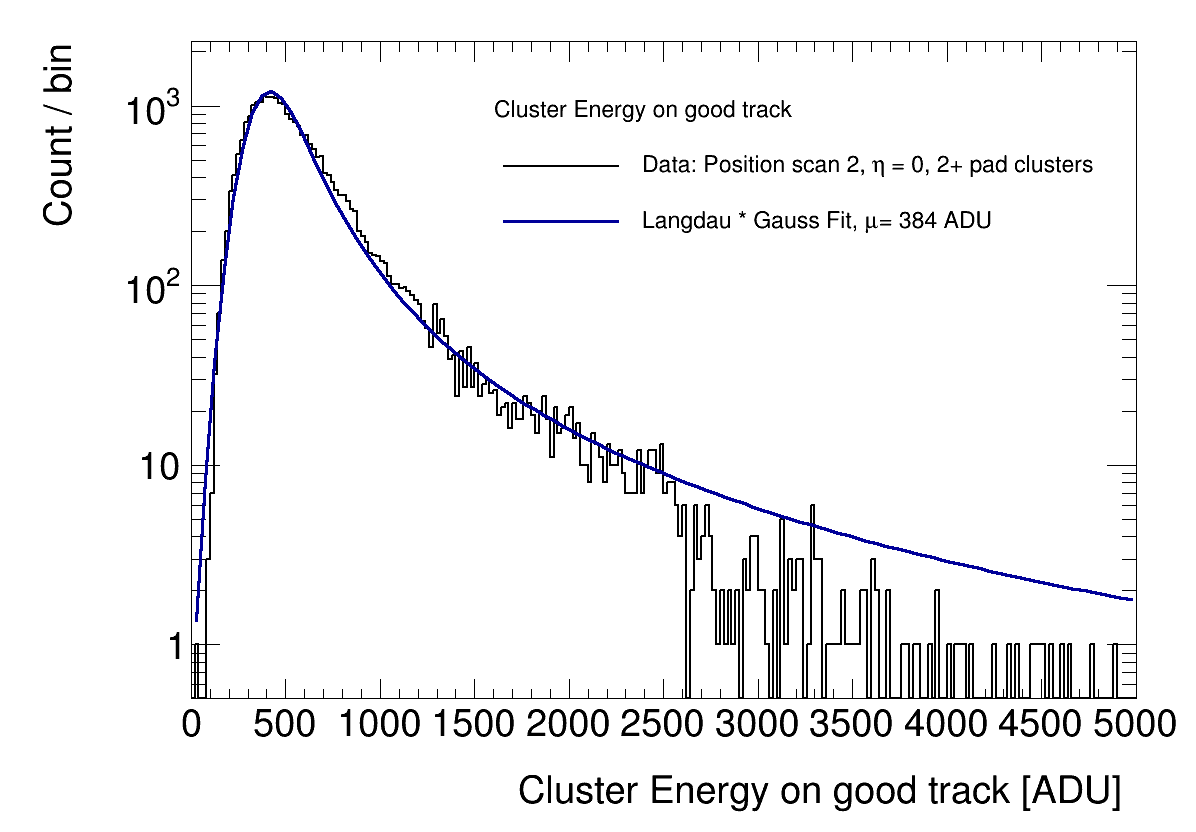

Info in <TCanvas::SaveSource>: C++ Macro file: scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTrackClusterEnergy.C has been generated


In [8]:
TH1 *hClusterEnergy = new TH1F("hClusterEnergy", ";Cluster Energy on good track [ADU];Count / bin", 250, 0, 5000);
TF1 *hClusterEnergyFit = nullptr;

{
    TCanvas *c1 = new TCanvas("TrackClusterEnergy", "TrackClusterEnergy", 1200, 860);
    //  c1->Divide(2, 1);
    int idx = 1;
    TPad *p = nullptr;

    p = (TPad *) c1->cd(idx++);
    c1->Update();
    p->SetLogy();

    T->Draw("TPCTrack.clusterE>>hClusterEnergy", cut, "goff");
    //  TGraph *gPhiDistortion = FitProfile(hPhiDistortion);

    hClusterEnergyFit = langaufit(hClusterEnergy,
                       {0, 5000},
                       {200, 500, (double) T->GetEntries(cut) * 10, 200},
                       {0, 0, 0, 0},
                       {5000, 5000, 1e10, 5000});
    hClusterEnergyFit->SetLineColor(kBlue + 2);

    hClusterEnergy->Draw();
    hClusterEnergyFit->Draw("same");
    //    gPhiDistortion->Draw("p");

    TLegend *leg = new TLegend(.4, .7, .95, .9,  + "Cluster Energy on good track");
    leg->AddEntry(hClusterEnergy, TString("Data: ") + description, "l");
    leg->AddEntry(hClusterEnergyFit,
                Form("Langdau * Gauss Fit, #mu= %.0f ADU", hClusterEnergyFit->GetParameter(1)), "l");
    leg->Draw();

    c1->Draw();
    SaveCanvas(c1,
             TString(_file0->GetName()) + TString(c1->GetName()), kFALSE);
}

# Resampling

## Direct sampling from cluster-E PDF

In [9]:
%%cpp -d

#include <cassert>

vector<double> dEdXResampling(const TH1 * hPDF, const int N_layer = 48)
{
    assert(hPDF);
    
    vector<double> d;
    
    for (int i = 0; i<N_layer; ++i)
    {
        d.push_back(hPDF -> GetRandom ());
    }
    
    return d;
}

## Truncated means

In [10]:
%%cpp -d


double dEdxSampleTruncatedMean(const double TruncatePercentage, const TH1 * hPDF, const int N_layer = 48)
{
    assert(TruncatePercentage >=0);
    assert(TruncatePercentage <1);
    
    const int N_keep = int (N_layer * (1-TruncatePercentage));
    
    vector<double> hits = dEdXResampling(hPDF, N_layer);
    
    sort(hits.begin(), hits.end()); 
    
    double sum = 0;
    for (int i =0; i<N_keep; ++i)
    {
        sum += hits[i];
    }
    
    const double mean = sum/N_keep;
    
    return mean;
}

In [11]:
%%cpp -d

TH1 * dEdxStatTruncatedMean(const TH1 * hPDF, TString name, const int N_sample, const int N_layer, const double TruncatePercentage, Color_t color)
{
    TH1 * hClusterEnergyTMean = (TH1 *) hClusterEnergy->Clone(name);
    hClusterEnergyTMean->Reset();
//     hClusterEnergyTMean->GetXaxis()->SetRangeUser(0, 1000);
    
    for (int sample = 0 ; sample < N_sample; ++sample)
    {
        
        const double mean = dEdxSampleTruncatedMean(TruncatePercentage, hClusterEnergy, N_layer);
        if (sample % 10000 == 0)
            cout <<name<<" - Sample "<<sample<<" = "<<mean<<endl;
//         const double mean = 0;
        hClusterEnergyTMean -> Fill(mean);
    }
    
    hClusterEnergyTMean->Sumw2();
    hClusterEnergyTMean->Fit("gaus","0");
    
    hClusterEnergyTMean->SetLineColor(color-3);
    hClusterEnergyTMean->SetMarkerColor(color);
    ((TF1 *)(hClusterEnergyTMean->GetListOfFunctions()->At(0)))->SetLineColor(color);
    
    return hClusterEnergyTMean;
    
}

## Likelihood fit method

In [12]:
%%cpp -d

double dEdxSampleML(const TH1 * hPDF, const TF1 * fFit, const int N_layer = 48)
{
    
    vector<double> hits = dEdXResampling(hPDF, N_layer);
    
    unique_ptr<TH1> hTrack ((TH1*) hPDF->Clone("hTrack")); hTrack->Reset();
    unique_ptr<TF1> fTrackFit (new TF1("fTrackFit", langaufun,0, 5000, 4));
    fTrackFit->SetParNames("Width", "MP", "Area", "GSigma");

    for (const auto hit : hits)
    {
        hTrack->Fill(hit);
    }
    
// Width                     =      62.8982   +/-   0.807918     	 (limited)
// MP                        =      384.351   +/-   1.42708      	 (limited)
// Area                      =       539387   +/-   3321.22      	 (limited)
// GSigma                    =      80.1467   +/-   1.50242      	 (limited)    
    fTrackFit->FixParameter(0, fFit->GetParameter(0));
    fTrackFit->SetParLimits(0, 0, 5000);
    fTrackFit->SetParameter(1, fFit->GetParameter(1) );
    fTrackFit->SetParLimits(1, 0, 5000);
    fTrackFit->SetParameter(2, N_layer);
    fTrackFit->SetParLimits(2, 0, N_layer*100);
    fTrackFit->FixParameter(3, fFit->GetParameter(3));
    fTrackFit->SetParLimits(3, 0, 5000);
    
    
//     TCanvas *c1 = new TCanvas("dEdxSampleML2", "dEdxSampleML2", 1200, 860);
//     hTrack->DrawClone();
    
// //     fTrackFit->DrawClone("");
// //     fTrackFit->Print("V");
    
//     hTrack->Fit(fTrackFit.get(), "LMN0Q"); // loglikelihood fit
    hTrack->Fit(fTrackFit.get(), "LN0Q"); // loglikelihood fit
    
//     fTrackFit->DrawClone("same");
//     c1->Draw();
    
    return fTrackFit->GetParameter(1);
}

In [13]:
%%cpp -d

TH1 * dEdxStatML(const TH1 * hPDF, TString name, const int N_sample, const int N_layer, const TF1 * fFit, Color_t color)
{
    TH1 * hClusterEnergyTMean = (TH1 *) hClusterEnergy->Clone(name);
    hClusterEnergyTMean->Reset();
//     hClusterEnergyTMean->GetXaxis()->SetRangeUser(0, 1000);
    
    for (int sample = 0 ; sample < N_sample; ++sample)
    {
        
        const double mean = dEdxSampleML(hClusterEnergy,  fFit, N_layer);
        if (sample % 100 == 0)
            cout <<name<<" - Sample "<<sample<<" = "<<mean<<endl;
//         const double mean = 0;
        hClusterEnergyTMean -> Fill(mean);
    }
    
    hClusterEnergyTMean->Sumw2();
    hClusterEnergyTMean->Fit("gaus","0");
    
    hClusterEnergyTMean->SetLineColor(color-3);
    hClusterEnergyTMean->SetMarkerColor(color);
    ((TF1 *)(hClusterEnergyTMean->GetListOfFunctions()->At(0)))->SetLineColor(color);
    
    return hClusterEnergyTMean;
    
}

## Run it

In [14]:

const int N_layer = 48;
const int N_sample = 10000;
TH1 * hClusterEnergyTMean5 = dEdxStatTruncatedMean(hClusterEnergy,"hClusterEnergyTMean5",N_sample, N_layer,.5, kRed+3);
TH1 * hClusterEnergyTMean3 = dEdxStatTruncatedMean(hClusterEnergy,"hClusterEnergyTMean3",N_sample, N_layer,.3, kGreen+3);
TH1 * hClusterEnergyTMean2 = dEdxStatTruncatedMean(hClusterEnergy,"hClusterEnergyTMean2",N_sample, N_layer,.2, kCyan+3);
TH1 * hClusterEnergyTMean1 = dEdxStatTruncatedMean(hClusterEnergy,"hClusterEnergyTMean1",N_sample, N_layer,.1, kBlue+3);
// TH1 * hClusterEnergyML = dEdxStatML(hClusterEnergy,"hClusterEnergyML",N_sample/10, N_layer,hClusterEnergyFit, kMagenta+3);
TH1 * hClusterEnergyML = dEdxStatML(hClusterEnergy,"hClusterEnergyML",N_sample, N_layer,hClusterEnergyFit, kMagenta+3);


hClusterEnergyTMean5 - Sample 0 = 343.154

****************************************
Minimizer is Minuit2
Chi2                      =      73.5555
NDf                       =            7
Edm                       =  1.28884e-06
NCalls                    =           57
Constant                  =      3009.67   +/-   37.5613     
Mean                      =      368.155   +/-   0.273451    
Sigma                     =      26.3236   +/-   0.195955     	 (limited)
hClusterEnergyTMean3 - Sample 0 = 408.4

****************************************
Minimizer is Minuit2
Chi2                      =      166.884
NDf                       =            9
Edm                       =  2.60646e-07
NCalls                    =           68
Constant                  =      2776.68   +/-   33.3452     
Mean                      =      422.541   +/-   0.309318    
Sigma                     =      28.2585   +/-   0.184469     	 (limited)
hClusterEnergyTMean2 - Sample 0 = 456.856

*************************

## Plot

Info in <TCanvas::Print>: png file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTruckatedMean.png has been created


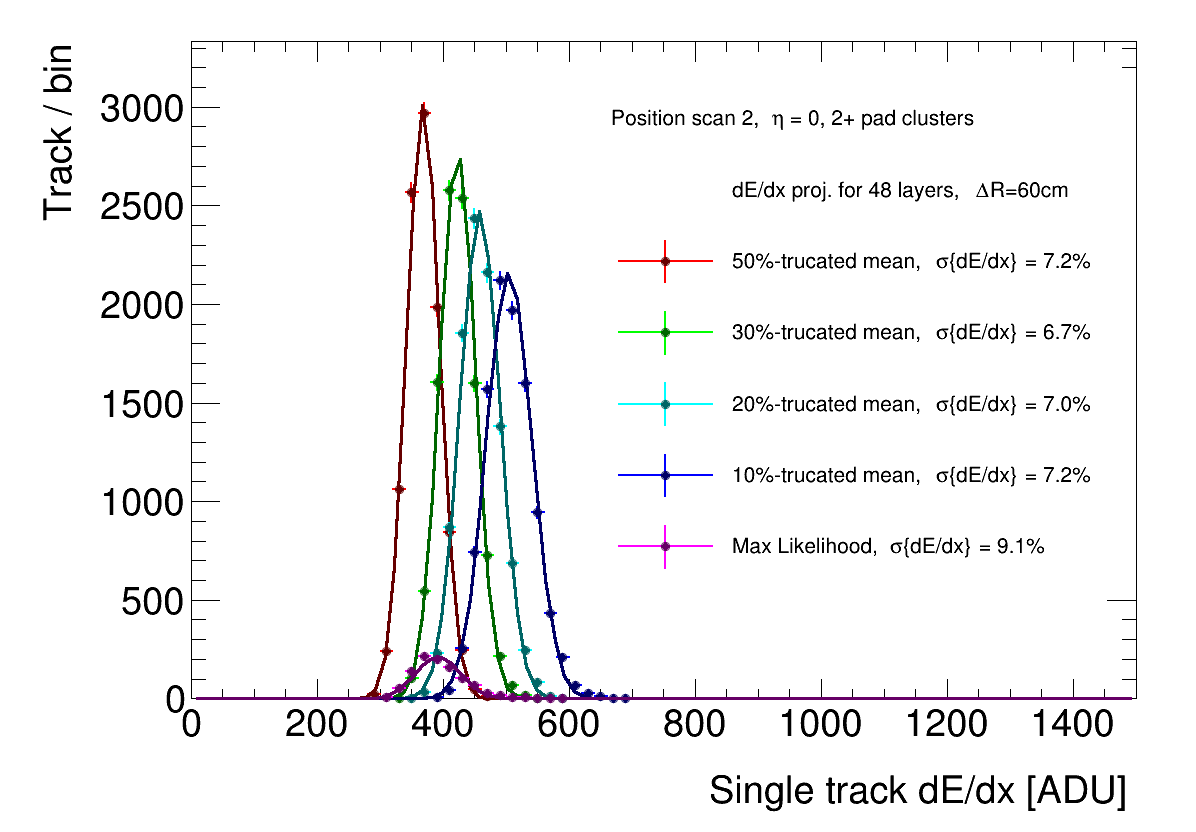

Save TH1 hframe
Save TH1 hClusterEnergyTMean5
Save TF1 gaus
Save TH1 hClusterEnergyTMean3
Save TF1 gaus
Save TH1 hClusterEnergyTMean2
Save TF1 gaus
Save TH1 hClusterEnergyTMean1
Save TF1 gaus
Save TH1 hClusterEnergyML
Save TF1 gaus


Info in <TCanvas::SaveAs>: ROOT file scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTruckatedMean.root has been created
Info in <TCanvas::SaveSource>: C++ Macro file: scan2/tpc_beam_ALL-0000.evt_TpcPrototypeGenFitTrkFitter.rootTruckatedMean.C has been generated


In [15]:
{
    TCanvas *c1 = new TCanvas("TruckatedMean", "TruckatedMean", 1200, 860);
    //  c1->Divide(2, 1);
    int idx = 1;
    TPad *p = nullptr;

    p = (TPad *) c1->cd(idx++);
    c1->Update();
//     p->SetLogy();
    p->DrawFrame(0,0,1500,N_sample/3,";Single track dE/dx [ADU];Track / bin");
    
    TLegend *leg = new TLegend(.5, .3, .95, .9,  description);
    leg->AddEntry("", Form("dE/dx proj. for %d layers, #DeltaR=60cm", N_layer),"");
    TF1 * fitfunc (nullptr);
    
    
    hClusterEnergyTMean5->Draw("same");
    fitfunc = (TF1 *)hClusterEnergyTMean5->GetListOfFunctions()->At(0);
    fitfunc->Draw("same");
    leg->AddEntry(hClusterEnergyTMean5, Form("50%%-trucated mean, #sigma{dE/dx} = %.1f%%",fitfunc->GetParameter(2)/fitfunc->GetParameter(1)*100), "lpe");
    
    hClusterEnergyTMean3->Draw("same");
    fitfunc = (TF1 *)hClusterEnergyTMean3->GetListOfFunctions()->At(0);
    fitfunc->Draw("same");
    leg->AddEntry(hClusterEnergyTMean3, Form("30%%-trucated mean, #sigma{dE/dx} = %.1f%%",fitfunc->GetParameter(2)/fitfunc->GetParameter(1)*100), "lpe");
    
    hClusterEnergyTMean2->Draw("same");
    fitfunc = (TF1 *)hClusterEnergyTMean2->GetListOfFunctions()->At(0);
    fitfunc->Draw("same");
    leg->AddEntry(hClusterEnergyTMean2, Form("20%%-trucated mean, #sigma{dE/dx} = %.1f%%",fitfunc->GetParameter(2)/fitfunc->GetParameter(1)*100), "lpe");
    
    hClusterEnergyTMean1->Draw("same");
    fitfunc = (TF1 *)hClusterEnergyTMean1->GetListOfFunctions()->At(0);
    fitfunc->Draw("same");
    leg->AddEntry(hClusterEnergyTMean1, Form("10%%-trucated mean, #sigma{dE/dx} = %.1f%%",fitfunc->GetParameter(2)/fitfunc->GetParameter(1)*100), "lpe");
    
    //TH1 * dEdxStatML(const TH1 * hPDF, TString name, const int N_sample, const int N_layer, const TF1 * fFit, Color_t color)
    hClusterEnergyML->Draw("same");
    fitfunc = (TF1 *)hClusterEnergyML->GetListOfFunctions()->At(0);
    fitfunc->Draw("same");
    leg->AddEntry(hClusterEnergyML, Form("Max Likelihood, #sigma{dE/dx} = %.1f%%",fitfunc->GetParameter(2)/fitfunc->GetParameter(1)*100), "lpe");
    
    leg->Draw();
    
    c1->Draw();
    SaveCanvas(c1,
             TString(_file0->GetName()) + TString(c1->GetName()), kFALSE);
}

# Scratch
If you're reading this you went too far

In [16]:
%jsroot off


In [17]:
T->Show(1)

======> EVENT:1
 nTrack          = 1
 TPCTrack        = 1
 TPCTrack.fUniqueID = 0
 TPCTrack.fBits  = 50331648
 TPCTrack.trackID = 0
 TPCTrack.chisq  = 23.254528
 TPCTrack.ndf    = 20
 TPCTrack.px     = -97.173088
 TPCTrack.py     = -23.578421
 TPCTrack.pz     = 1.202279
 TPCTrack.x      = -0.211332
 TPCTrack.y      = -0.375730
 TPCTrack.z      = -24.449318
 TPCTrack.nCluster = 16
 TPCTrack.clusterX[16] = -39.385849 , -40.617844 , -41.832355 , -43.049511 , -44.263920 , 
                    nan , -46.692413 , -47.901363 , -49.135662 , -50.334980 , 
                    -51.545620 , -52.761135 , -53.985523 , -55.198902 , -56.263981 , 
                    -57.624031 

 TPCTrack.clusterY[16] = -9.957177 , -10.183629 , -10.479493 , -10.764770 , -11.061008 , 
                    nan , -11.654788 , -11.972879 , -12.189231 , -12.546126 , 
                    -12.857477 , -13.149261 , -13.405362 , -13.705721 , -14.590414 , 
                    -14.312993 

 TPCTrack.clusterZ[16] = -23.852617 , -2

In [18]:
hClusterEnergy->GetSum()

input_line_174:2:18: error: no member named 'GetSum' in 'TH1'
 hClusterEnergy->GetSum()
 ~~~~~~~~~~~~~~  ^


In [19]:
hClusterEnergyTMean5->GetListOfFunctions()->At(0)->Print()

Formula based function:     gaus 
                 gaus : gaus Ndim= 1, Npar= 3, Number= 100 
 Formula expression: 
	[Constant]*exp(-0.5*((x-[Mean])/[Sigma])*((x-[Mean])/[Sigma])) 
Contained histogram
TH1.Print Name  = Func, Entries= 300, Total sum= 13239.2
